Prepare the environment and import all library we need

In [1]:
# built-in libs
import json
import pickle
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# 3rd party libs
import hanlp
import opencc
import pandas as pd
import wikipedia
from hanlp.components.pipeline import Pipeline
from pandarallel import pandarallel

# our own libs
from utils import load_json

pandarallel.initialize(progress_bar=True, verbose=0)
wikipedia.set_lang("zh")

2023-06-03 21:33:28.300543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 21:33:29.811659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Preload the data.

In [2]:
TRAIN_DATA = load_json("../data/public_train.jsonl")
TEST_DATA = load_json("../data/private_test.jsonl")
CONVERTER_T2S = opencc.OpenCC("t2s.json")
CONVERTER_S2T = opencc.OpenCC("s2t.json")

Data class for type hinting

In [3]:
@dataclass
class Claim:
    data: str

@dataclass
class AnnotationID:
    id: int

@dataclass
class EvidenceID:
    id: int

@dataclass
class PageTitle:
    title: str

@dataclass
class SentenceID:
    id: int

@dataclass
class Evidence:
    data: List[List[Tuple[AnnotationID, EvidenceID, PageTitle, SentenceID]]]

### Helper function

For the sake of consistency, we convert traditional to simplified Chinese first before converting it back to traditional Chinese.  This is due to some errors occuring when converting traditional to traditional Chinese.

In [4]:
def do_st_corrections(text: str) -> str:
    simplified = CONVERTER_T2S.convert(text)

    return CONVERTER_S2T.convert(simplified)

We use constituency parsing to separate part of speeches or so called constituent to extract noun phrases.  In the later stages, we will use the noun phrases as the query to search for relevant documents.  

In [5]:
def get_nps_hanlp(
    predictor: Pipeline,
    d: Dict[str, Union[int, Claim, Evidence]],
) -> List[str]:
    claim = d["claim"]
    tree = predictor(claim)["con"]
    nps = [
        do_st_corrections("".join(subtree.leaves()))
        for subtree in tree.subtrees(lambda t: t.label() == "NP")
    ]

    return nps

Precision refers to how many related documents are retrieved.  Recall refers to how many relevant documents are retrieved.  

In [6]:
def calculate_precision(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    precision = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        # Extract all ground truth of titles of the wikipedia pages
        # evidence[2] refers to the title of the wikipedia page
        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])

        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        if len(predicted_pages) != 0:
            precision += len(hits) / len(predicted_pages)

        count += 1

    # Macro precision
    print(f"Precision: {precision / count}")


def calculate_recall(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    recall = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])
        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        recall += len(hits) / len(gt_pages)
        count += 1

    print(f"Recall: {recall / count}")

The default amount of documents retrieved is at most five documents.  This `num_pred_doc` can be adjusted based on your objective.  Save data in jsonl format.

In [7]:
def save_doc(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
    mode: str = "train",
    num_pred_doc: int = 5,
) -> None:
    with open(
        f"../data/{mode}_doc{num_pred_doc}.jsonl",
        "w",
        encoding="utf8",
    ) as f:
        for i, d in enumerate(data):
            d["predicted_pages"] = list(predictions.iloc[i])
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

### Main function for document retrieval

### Step 1. Get noun phrases from hanlp consituency parsing tree

Setup [HanLP](https://github.com/hankcs/HanLP) predictor (1 min)

In [ ]:
predictor = (hanlp.pipeline().append(
    hanlp.load("FINE_ELECTRA_SMALL_ZH"),
    output_key="tok",
).append(
    hanlp.load("CTB9_CON_ELECTRA_SMALL"),
    output_key="con",
    input_key="tok",
))

We will skip this process which for creating parsing tree when demo on class

In [ ]:
hanlp_file = f"../data/hanlp_con_results.pkl"
if Path(hanlp_file).exists():
    with open(hanlp_file, "rb") as f:
        hanlp_results = pickle.load(f)
else:
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TRAIN_DATA]
    with open(hanlp_file, "wb") as f:
        pickle.dump(hanlp_results, f)

Get pages via wiki online api

In [ ]:
NUM_DOC = 10
def get_pred_pages(series_data: pd.Series) -> Set[Dict[int, str]]:
    results = []
    tmp_muji = []
    # wiki_page: its index showned in claim
    mapping = {}
    claim = series_data["claim"]
    nps = series_data["hanlp_results"]
    first_wiki_term = []

    for i, np in enumerate(nps):
        # Simplified Traditional Chinese Correction
        wiki_search_results = [
            do_st_corrections(w) for w in wikipedia.search(np)
        ]

        # Remove the wiki page's description in brackets
        wiki_set = [re.sub(r"\s\(\S+\)", "", w) for w in wiki_search_results]
        wiki_df = pd.DataFrame({
            "wiki_set": wiki_set,
            "wiki_results": wiki_search_results
        })

        # Elements in wiki_set --> index
        # Extracting only the first element is one way to avoid extracting
        # too many of the similar wiki pages
        grouped_df = wiki_df.groupby("wiki_set", sort=False).first()
        candidates = grouped_df["wiki_results"].tolist()
        # muji refers to wiki_set
        muji = grouped_df.index.tolist()

        for prefix, term in zip(muji, candidates):
            if prefix not in tmp_muji:
                matched = False

                # Take at least one term from the first noun phrase
                if i == 0:
                    first_wiki_term.append(term)

                # Walrus operator :=
                # https://docs.python.org/3/whatsnew/3.8.html#assignment-expressions
                # Through these filters, we are trying to figure out if the term
                # is within the claim
                if (((new_term := term) in claim) or
                    ((new_term := term.replace("·", "")) in claim) or
                    ((new_term := term.split(" ")[0]) in claim) or
                    ((new_term := term.replace("-", " ")) in claim)):
                    matched = True

                elif "·" in term:
                    splitted = term.split("·")
                    for split in splitted:
                        if (new_term := split) in claim:
                            matched = True
                            break

                if matched:
                    # post-processing
                    term = term.replace(" ", "_")
                    term = term.replace("-", "")
                    results.append(term)
                    mapping[term] = claim.find(new_term)
                    tmp_muji.append(new_term)

    # 5 is a hyperparameter
    if len(results) > NUM_DOC:
        assert -1 not in mapping.values()
        results = sorted(mapping, key=mapping.get)[:NUM_DOC]
    elif len(results) < 1:
        results = first_wiki_term

    return set(results)

In [ ]:
doc_path = f"../data/train_doc{NUM_DOC}.jsonl"
if Path(doc_path).exists():
    with open(doc_path, "r", encoding="utf8") as f:
        predicted_results = pd.Series([
            set(json.loads(line)["predicted_pages"])
            for line in f
        ])
else:
    train_df = pd.DataFrame(TRAIN_DATA)
    train_df.loc[:, "hanlp_results"] = hanlp_results
    predicted_results = train_df.parallel_apply(get_pred_pages, axis=1)
    save_doc(TRAIN_DATA, predicted_results, mode="train", num_pred_doc=NUM_DOC)

### Step 2. Calculate our results

In [8]:
with open('/nfs/nas-6.1/wclu/AICUP/2023/NCKU-AICUP2023-baseline/data/train_doc10.jsonl', "r", encoding="utf8") as f:
    predicted_results = pd.Series([
        set(json.loads(line)["predicted_pages"])
        for line in f
    ])

In [12]:
doc100_df = pd.read_pickle('/nfs/nas-6.1/wclu/AICUP/2023/aicup-2023-nlp/data/train_doc100.pkl')
doc100_df['api'] = predicted_results

In [15]:
def evi_doc(evidence_list):
    if len(evidence_list[0])>1 and evidence_list[0][1] == None:
        return None
    e_list = []
    for evidence in evidence_list[0]:
        id = evidence[2]
        if not(id in e_list):
            e_list.append(id)
    return e_list
doc100_df['ground_doc'] = doc100_df['evidence'].apply(evi_doc)
doc100_df['api'] = predicted_results
train_df_info = doc100_df[doc100_df['label']!='NOT ENOUGH INFO'].reset_index(drop=True)

In [36]:
from tqdm.auto import tqdm
score = []
total = len(train_df_info)
for NUM_PAGE in tqdm(range(100)):
    wrong = 0
    for i in range(total):
        for e in train_df_info['ground_doc'][i]:
            if not((e in train_df_info['predicted_doc'][i][:NUM_PAGE]) or (e in list(train_df_info['api'][i])[:10])):
                wrong += 1
                break
    score.append(round((total-wrong)/total, 3))


  0%|          | 0/100 [00:00<?, ?it/s]

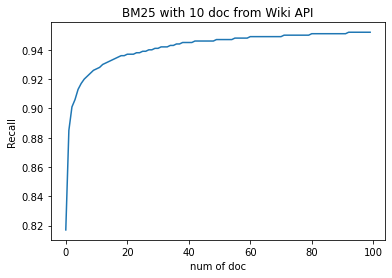

In [37]:
import matplotlib.pyplot as plt
plt.title("BM25 with 10 doc from Wiki API") # title
plt.ylabel("Recall") # y label
plt.xlabel("num of doc") # x label
plt.plot(score)


In [46]:
from tqdm.auto import tqdm
NUM_BM25 = 2
predicted_pages = []
for i in tqdm(range(len(doc100_df))):
    bm25 = doc100_df['predicted_doc'][i][:2]
    api = doc100_df['api'][i]
    for doc in bm25:
        api.add(doc)
    predicted_pages.append(api)

  0%|          | 0/8049 [00:00<?, ?it/s]

In [47]:
doc100_df['temp'] = predicted_pages


In [48]:
doc100_df['temp'].apply(lambda x: len(x)).mean()

6.764070070816251

In [ ]:
doc100_df['temp'] = predicted_pages
train_df_info = doc100_df[doc100_df['label']!='NOT ENOUGH INFO'].reset_index(drop=True)

In [ ]:
wrong = 0
for i in range(total):
    for e in train_df_info['ground_doc'][i]:
        if not((e in train_df_info['temp'][i])):
            wrong += 1
            break
round((total-wrong)/total, 3)

In [ ]:
save_doc(TEST_DATA, doc100_df['temp'], mode="test_private", num_pred_doc=12)

### Step 3. Repeat the same process on test set
Create parsing tree

In [ ]:
hanlp_test_file = f"data/hanlp_con_test_results.pkl"
if Path(hanlp_test_file).exists():
    with open(hanlp_test_file, "rb") as f:
        hanlp_results = pickle.load(f)
else:
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TEST_DATA]
    with open(hanlp_test_file, "wb") as f:
        pickle.dump(hanlp_results, f)

Get pages via wiki online api

In [ ]:
test_doc_path = f"../data/test_doc{NUM_DOC}.jsonl"
if Path(test_doc_path).exists():
    with open(test_doc_path, "r", encoding="utf8") as f:
        test_results = pd.Series(
            [set(json.loads(line)["predicted_pages"]) for line in f])
else:
    test_df = pd.DataFrame(TEST_DATA)
    test_df.loc[:, "hanlp_results"] = hanlp_results
    test_results = test_df.parallel_apply(get_pred_pages, axis=1)
    save_doc(TEST_DATA, test_results, mode="test", num_pred_doc=NUM_DOC)

In [ ]:
doc100_test_df = pd.read_pickle('/nfs/nas-6.1/wclu/AICUP/2023/aicup-2023-nlp/data/test_doc100.pkl')
doc100_test_df['api'] = test_results


In [ ]:
NUM_BM25 = 2
predicted_pages = []
for i in tqdm(range(len(doc100_test_df))):
    bm25 = doc100_test_df['predicted_doc'][i][:2]
    api = doc100_test_df['api'][i]
    for doc in bm25:
        api.add(doc)
    predicted_pages.append(api)

In [ ]:
doc100_test_df['temp'] = predicted_pages

In [ ]:
doc100_test_df

In [ ]:
save_doc(TEST_DATA, doc100_test_df['temp'], mode="test", num_pred_doc=NUM_DOC+NUM_BM25)